In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

# Build an absolute path from this notebook's parent directory
module_path = os.path.abspath(os.getcwd())

# Add to sys.path if not already present
if module_path not in sys.path:
   sys.path.append(module_path)

import numpy as np
from aerosandbox import Airfoil, KulfanAirfoil
from src.airfoil import airfoil_modifications

import plotly.graph_objects as go

In [2]:
from src.vae import Decoder, Encoder
import tensorflow as tf

BATCH_SIZE = 4
NPV = 12
LATENT_DIM = 128

decoder = Decoder(NPV, LATENT_DIM)

dummy_latent_vector = tf.random.normal(shape=(BATCH_SIZE, LATENT_DIM))

coords, weights, params = decoder(dummy_latent_vector)

n = 0 

airfoil = Airfoil(coordinates=coords[n].numpy())
airfoil.draw()

kulfan = KulfanAirfoil(lower_weights=weights[n][0], upper_weights=weights[n][1], leading_edge_weight=params[n][0], TE_thickness=params[n][1])
kulfan.draw()

2025-10-20 22:15:13.219339: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-20 22:15:14.535097: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-20 22:15:18.843872: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-20 22:15:20.103006: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


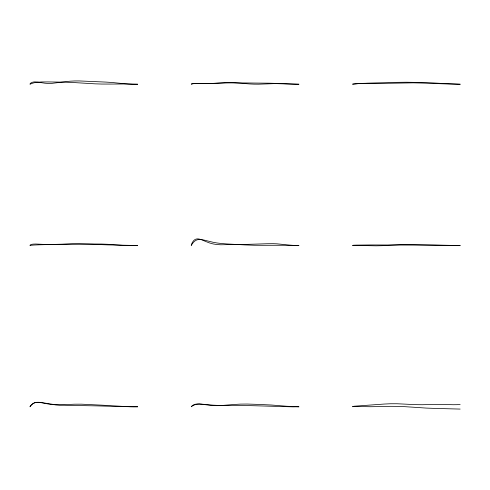

In [28]:
from src.utils import generate_and_plot_airfoils
from src.vae import Decoder, Encoder
from src.gan.generator import CSTGenerator 

BATCH_SIZE = 9
NPV = 12
LATENT_DIM = 128

generator = Decoder(NPV, LATENT_DIM)
# generator = CSTGenerator(NPV, LATENT_DIM)

generate_and_plot_airfoils(generator, num_airfoils=BATCH_SIZE, figsize=(5,5))


In [6]:
airfoil = Airfoil(name="NACA0012")
# airfoil.draw(show=False, fill=False)
kulfan = airfoil.to_kulfan_airfoil(12)
kulfan.kulfan_parameters

{'lower_weights': array([-0.17443337, -0.14999311, -0.19304352, -0.09233462, -0.25399501,
        -0.02409511, -0.26620344, -0.05251675, -0.19295467, -0.11732873,
        -0.14729293, -0.13982363]),
 'upper_weights': array([0.17443337, 0.14999311, 0.19304352, 0.09233462, 0.25399501,
        0.02409511, 0.26620344, 0.05251675, 0.19295467, 0.11732873,
        0.14729293, 0.13982363]),
 'leading_edge_weight': np.float64(-1.9290125052862095e-15),
 'TE_thickness': np.float64(0.002529791573506454)}

In [9]:
x = np.array([50,2,60])

def standardize(x):
  return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

standardize(x)

array([ 0.50034662, -1.39570373,  0.89535711])

In [5]:
airfoils = [Airfoil(coordinates=np.random.rand(10, 2)) for _ in range(16)]  # Example airfoils
plot_samples(None, airfoils, fname='airfoil_plot')

In [2]:
fig = go.Figure()
airfoil = Airfoil(name="NACA0012")
airfoil.draw(show=False, fig=fig, fill=False)
airfoil2 = Airfoil(name="NACA0008")
airfoil2.draw(show=True, fig=fig, fill=False, color="green")

In [3]:
kulfan = airfoil.to_kulfan_airfoil(n_weights_per_side=8)
params = kulfan.kulfan_parameters
params

{'lower_weights': array([-0.1728844 , -0.15156292, -0.17376306, -0.12768079, -0.16481846,
        -0.126376  , -0.14589789, -0.13919961]),
 'upper_weights': array([0.1728844 , 0.15156292, 0.17376306, 0.12768079, 0.16481846,
        0.126376  , 0.14589789, 0.13919961]),
 'leading_edge_weight': np.float64(3.5974444559735816e-16),
 'TE_thickness': np.float64(0.0025478997333240466)}

In [4]:
import numpy as np
from scipy.special import comb

def generate_airfoil(N1, N2, lower_weights, upper_weights, leading_edge_weight, TE_thickness, n_points_per_side):
    # Gerar pontos espaçados cosinicamente
    x = (1 - np.cos(np.linspace(0, np.pi, n_points_per_side))) / 2  

    # Função Classe
    C = (x ** N1) * ((1 - x) ** N2)

    def shape_function(w):
        # Função de forma (polinômios de Bernstein)
        N = len(w) - 1  # Ordem dos polinômios

        K = comb(N, np.arange(N + 1))  # Coeficientes binomiais de Bernstein

        dims = (len(w), len(x))

        def wide(vector):
            return np.tile(np.reshape(vector, (1, dims[1])), (dims[0], 1))

        def tall(vector):
            return np.tile(np.reshape(vector, (dims[0], 1)), (1, dims[1]))

        S_matrix = (
            tall(K)
            * wide(x) ** tall(np.arange(N + 1))
            * wide(1 - x) ** tall(N - np.arange(N + 1))
        )  # Polinômios de Bernstein multiplicados pelos pesos

        S_x = np.sum(tall(w) * S_matrix, axis=0)

        # Calcular a saída y
        y = C * S_x
        return y

    y_lower = shape_function(lower_weights)
    y_upper = shape_function(upper_weights)

    # Espessura do bordo de fuga (TE thickness)
    y_lower -= x * TE_thickness / 2
    y_upper += x * TE_thickness / 2

    # Modificação do bordo de ataque (LEM)
    y_lower += leading_edge_weight * x * (1 - x) ** (len(lower_weights) + 0.5)
    y_upper += leading_edge_weight * x * (1 - x) ** (len(upper_weights) + 0.5)

    # Criar coordenadas do aerofólio
    x = np.concatenate((x[::-1], x[1:]))
    y = np.concatenate((y_upper[::-1], y_lower[1:]))
    coordinates = np.stack((x, y), axis=1)

    return coordinates

coords = generate_airfoil(0.5, 1, params["lower_weights"], params["upper_weights"], 0, 0,150)
coords.shape

(299, 2)

In [45]:
import numpy as np
from scipy.special import comb
import tensorflow as tf
from tensorflow.keras.layers import Layer

class CSTLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CSTLayer, self).__init__(**kwargs)
        self.N1 = 0.5
        self.N2 = 1
        self.TE_thickness = 0.0
        self.leading_edge_weight = 0.0
        self.n_points_per_side = 150

    def call(self, inputs):
        # Inputs is a 3D tensor: (batch_size, 2, num_weights)
        # For example, shape: (1, 2, 12)
        batch_size = tf.shape(inputs)[0]
        num_weights = tf.shape(inputs)[2]

        # Reshape inputs to separate lower and upper weights
        # Shape: (batch_size, 2, num_weights) -> (2, batch_size * num_weights)
        inputs = tf.reshape(inputs, (batch_size * 2, num_weights))

        # Split into lower and upper weights
        lower_weights = inputs[:batch_size, :]  # Shape: (batch_size, num_weights)
        upper_weights = inputs[batch_size:, :]  # Shape: (batch_size, num_weights)

        # Generate cosinically spaced points
        x = (1 - tf.cos(tf.linspace(0.0, np.pi, self.n_points_per_side))) / 2

        # Class function
        C = (x ** self.N1) * ((1 - x) ** self.N2)

        def shape_function(w):
            # Shape function (Bernstein polynomials)
            N = tf.cast(tf.shape(w)[1] - 1, dtype=tf.float32)  # num_weights - 1

            # Bernstein binomial coefficients
            K = tf.cast(comb(N.numpy(), np.arange(N.numpy() + 1)), dtype=tf.float32)

            dims = (tf.shape(w)[1], tf.shape(x)[0])

            def wide(vector):
                return tf.tile(tf.reshape(vector, (1, dims[1])), (dims[0], 1))

            def tall(vector):
                return tf.tile(tf.reshape(vector, (dims[0], 1)), (1, dims[1]))

            S_matrix = (
                tall(K)
                * wide(x) ** tall(tf.cast(np.arange(N + 1), dtype=tf.float32))
                * wide(1 - x) ** tall(tf.cast(N - np.arange(N + 1), dtype=tf.float32))
            )  # Bernstein polynomials multiplied by weights

            S_x = tf.reduce_sum(tall(w) * S_matrix, axis=0)

            # Calculate the output y
            y = C * S_x
            return y

        # Apply shape function to lower and upper weights
        y_lower = shape_function(lower_weights)
        y_upper = shape_function(upper_weights)

        # Trailing edge thickness (TE thickness)
        y_lower -= x * self.TE_thickness / 2
        y_upper += x * self.TE_thickness / 2

        # Leading edge modification (LEM)
        y_lower += self.leading_edge_weight * x * (1 - x) ** (tf.cast(tf.shape(lower_weights)[1], dtype=tf.float32) + 0.5)
        y_upper += self.leading_edge_weight * x * (1 - x) ** (tf.cast(tf.shape(upper_weights)[1], dtype=tf.float32) + 0.5)

        # Create airfoil coordinates
        x = tf.concat([x[::-1], x[1:]], axis=0)
        y = tf.concat([y_upper[::-1], y_lower[1:]], axis=0)
        coordinates = tf.stack([x, y], axis=1)

        return coordinates

In [46]:
# Example input tensor from Conv2D layer
input_tensor = tf.random.normal((1, 2, 12))  # Shape: (1, 2, 12)

# Instantiate CSTLayer
cst_layer = CSTLayer()

# Pass input through CSTLayer
output_coordinates = cst_layer(input_tensor)

(299, 2)


In [44]:
fig = go.Figure()

airfoil = Airfoil(name="NACA8808")
airfoil.draw(fig=fig, show=False)

kulfan = airfoil.to_kulfan_airfoil(12)
np.array([kulfan.lower_weights, kulfan.upper_weights]).shape

layer = CSTLayer()
coords = layer(np.array([kulfan.lower_weights, kulfan.upper_weights]))

test = Airfoil(coordinates=coords)
test.draw(fig=fig, color="red")

In [53]:
airfoil = Airfoil("NACA0012")
airfoil.coordinates.shape
airfoil = airfoil.repanel(75)
airfoil.coordinates.shape

(149, 2)

In [ ]:
fig = go.Figure()
airfoil = Airfoil(name="NACA4412")
airfoil.draw(show=False, fig=fig, fill=False)
random_kulfan = KulfanAirfoil(lower_weights=np.array([1, 1]), upper_weights=np.array([0.2,0.2]), leading_edge_weight=0, TE_thickness=0, N1=0.5, N2=1)
random_kulfan.draw(fig=fig, show=True, fill=False, color="green")

In [ ]:
from src import run_xfoil
output = run_xfoil(airfoil, 0, 80, 2)
output

In [ ]:
output = airfoil.generate_polars(alpha_i=-5, alpha_f=20, alpha_step=0.25)

In [ ]:
airfoil.plot_polars()

In [ ]:
airfoil.polars[0]

In [3]:
airfoil_database_path = asb._asb_root / "geometry" / "airfoil" / "airfoil_database"

UIUC_airfoils = [
    asb.Airfoil(name=filename.stem).normalize()
    for filename in airfoil_database_path.iterdir() if filename.suffix == ".dat"
]

In [11]:
rand_airfoil = lambda: np.random.choice(UIUC_airfoils)
airfoil = rand_airfoil()

In [ ]:
airfoil.generate_polars()
airfoil.plot_polars()